In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler
from google.colab import drive
%matplotlib inline

# 1. Монтируем Google Диск
drive.mount('/content/drive')

file_path_data = "/content/drive/My Drive/Colab/IKT/IKT_1/data_test.npy"
file_path_etalon = "/content/drive/My Drive/Colab/IKT/IKT_1/etalon_3.npy"
#file_path_etalon = "/etalon.npy"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
def preprocess_data(data, etalon, limit = 100): #limits в град/ч

    omega = data[:,[1, 2, 3]]/np.pi*180*200*3600 #перевод в град/ч

    in_peak = False
    begin = 0
    end = 0
    omega_data_cols = [0,1,2]
    transition = np.array([], dtype=int)

    for i in omega_data_cols:
        domega = omega[1:omega.shape[0], i] - omega[0:omega.shape[0]-1, i]
        j=0
        while (j < domega.size):
            if abs(domega[j]) > limit:
                begin = j
                while abs(domega[j]) > limit:
                    j += 1
                end = j
                transition = np.concatenate((transition, np.arange(begin+1, end+1, dtype=int)))
            else:
                j += 1
    print(transition)
    data_corr = np.delete(data, transition, axis=0)
    etalon_corr = np.delete(etalon, transition, axis=0)
    return data_corr, etalon_corr

In [61]:
def get_diff(X, diff):
  # Вычисляем разницу между текущей и 3-мя строками назад
    diff_real = np.abs(X[3:] - X[:-3])  # Форма (N-3, M)

    # Проверяем условие (хотя бы один элемент в строке < diff)
    condition = np.any(diff_real >= diff, axis=1)  # Форма (N-3,)

    # Получаем индексы строк, где условие True (учитываем смещение +3)
    valid_indices = np.where(condition)[0] + 3  # Индексы исходного массива

    # Создаём итоговую маску (пример: первые 3 элемента + valid_indices)
    mask = np.hstack((np.array([0, 1, 2]), valid_indices))  # Индексы начинаются с 0

    return mask

In [62]:
def get_coefs_Logictic_Regression_w(X, y, i, diff = 0.0025):

  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, i-1])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, i-1])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, i-1])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, i-1]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, i-1]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, i-1]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, i-1]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, i-1]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, i-1]**3)

  X.insert(16, 23, X.iloc[:, i-1]**2)
  X.insert(17, 24, X.iloc[:, i-1]**3)

  X_y = pd.concat([X, y], axis = 1)

  plt.figure(figsize = (12, 8))
  plt.scatter(np.linspace(0, y.shape[0], y.shape[0]), y, alpha=0.05, color = 'red', label = 'etalon')
  plt.scatter(np.linspace(0, X.iloc[:, i-4].shape[0], X.iloc[:, i-4].shape[0]), X.iloc[:, i-4], alpha=0.05, color = 'green', label = 'data')
  plt.xlim(27500, 37500)
  plt.legend()
  plt.show()

  # mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
  # X_y = X_y[mask < diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)
  coefs = model.coef_
  intercept = model.intercept_

  to_return = [coefs] + [intercept]

  y_pred = model.predict(X_test)
  error = mean_squared_error(y_test, y_pred)

  y_pred_full = model.predict(X)

  plt.figure(figsize = (12, 8))
  plt.scatter(np.linspace(0, y.shape[0], y.shape[0]), y, alpha=0.05, color = 'red', label = 'etalon')
  plt.scatter(np.linspace(0, y_pred_full.shape[0], y_pred_full.shape[0]), y_pred_full, alpha=0.05, color = 'green', label = 'predict')
  plt.xlim(27500, 37500)
  plt.title(f'new_{i}')
  plt.legend()
  plt.show()

  print('Error for w before:', mean_squared_error(X.iloc[:, i-4], y))
  print('Error for w after:', error)
  return to_return, y_pred_full

In [63]:
def get_coefs_Logictic_Regression_omega(X, y, i, diff = 0.025):

  """Тут вроде как-то вот так по умному пишут описание функции.
     В данной функции на вход мы получаем фичи и таргеты и строим линейную регрессию"""

  #Добавим новые признаки по индексу
  print(X.head())
  X.insert(7, 14, X.iloc[:, 0] * X.iloc[:, 2+i])
  X.insert(8, 15, X.iloc[:, 1] * X.iloc[:, 2+i])
  X.insert(9, 16, X.iloc[:, 2] * X.iloc[:, 2+i])

  X.insert(10, 17, X.iloc[:, 0] * X.iloc[:, 2+i]**2)
  X.insert(11, 18, X.iloc[:, 1] * X.iloc[:, 2+i]**2)
  X.insert(12, 19, X.iloc[:, 2] * X.iloc[:, 2+i]**2)

  X.insert(13, 20, X.iloc[:, 0] * X.iloc[:, 2+i]**3)
  X.insert(14, 21, X.iloc[:, 1] * X.iloc[:, 2+i]**3)
  X.insert(15, 22, X.iloc[:, 2] * X.iloc[:, 2+i]**3)

  X.insert(16, 23, X.iloc[:, 2+i]**2)
  X.insert(17, 24, X.iloc[:, 2+i]**3)

  X.insert(18, 25, X.iloc[:, 2+i] - X.iloc[:, 6])
  X.drop(13, axis =1, inplace = True)
  print(X.head())

  #В первую очередь нужно выделить ту часть, которая находится на плато, для этого посмотрим на максимальную разность значений на плато
  X_y = pd.concat([X, y], axis = 1)

  #Вот я пока не знаю как подобрать нормально коэффициент, поэтому пока будет так

  # mask = np.abs(X_y.iloc[:, -1] - X_y.iloc[:, -1].shift(3))
  # X_y_sort = X_y.copy()
  # X_y = X_y[mask <= diff]

  X = X_y.iloc[:, :-1]
  y = X_y.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression(fit_intercept=True)
  model.fit(X_train, y_train)
  coefs = model.coef_
  intercept = model.intercept_

  to_return = [coefs] + [intercept]

  y_pred = model.predict(X)
  #error = mean_squared_error(y_test, y_pred)
  #print(mean_squared_error(X.iloc[:, i-1], y))
  #print(error)
  return to_return, y_pred

In [64]:
def full_LogicticRegression(file_path_data, file_path_etalon):
  #Подгружаем данные
  data = np.load(file_path_data)
  etalon = np.load(file_path_etalon)

  data, etalon = preprocess_data(data, etalon)

  #Переводим их в датафрейм
  data = pd.DataFrame(data)
  etalon = pd.DataFrame(etalon)

  np.save(f'Time.npy', data.iloc[:, 0])
  #Разделяем по колонкам для работы с омегой и с ускорением
  columns_omega = [1, 2, 3, 10, 11, 12, 13]
  columns_w = [4, 5, 6, 7, 8, 9, 13]
  data_fichi_omega = data[columns_omega]
  data_fichi_w = data[columns_w]

  #Переводим данные: омеги в радианы в секунду, а ускорения в м/с^2
  data_targets_omega = etalon[[1, 2, 3]]/3600*np.pi/180
  data_targets_w = etalon[[4, 5, 6]]

  for i in range(3):
    data_fichi_omega.iloc[:, i] = data_fichi_omega.iloc[:, i]*200
    data_fichi_w.iloc[:, i] = data_fichi_w.iloc[:, i]*200

  #Тут строим график, чтобы убедиться в правильности преобразований
  # plt.figure(figsize = (18, 15))
  # plt.scatter(data.iloc[:, 0], data_fichi_omega.iloc[:, 0], alpha=0.05)

  # mask = get_diff(data_targets_omega, 0.25)
  # print(data_fichi_omega.index)


  # data_fichi_omega = data_fichi_omega.iloc[mask]
  # data_fichi_w = data_fichi_w.iloc[mask]
  # data_targets_omega = data_targets_omega.iloc[mask]
  # data_targets_w = data_targets_w.iloc[mask]

  plt.figure()
  plt.scatter(data.iloc[:, 0], data_targets_omega.iloc[:, 2], alpha=0.05)
  plt.show()

  plt.figure()
  plt.scatter(data.iloc[:, 0], data_targets_w.iloc[:, 0], alpha=0.05)
  plt.show()

  plt.figure()
  plt.scatter(np.linspace(0, data_targets_w.iloc[:, 0].shape[0], data_targets_w.iloc[:, 0].shape[0]), data_targets_w.iloc[:, 0])
  plt.xlim(31475, 31500)
  plt.ylim(0, 2.5)
  plt.show()

  plt.figure()
  plt.scatter(np.linspace(0, data_targets_omega.iloc[:, 2].shape[0], data_targets_omega.iloc[:, 2].shape[0]), data_targets_omega.iloc[:, 2])
  plt.xlim(31475, 31500)
  plt.show()


  #Теперь можно начинать лутать коэффициенты
  coefs = {}
  #Тут коэффициенты для омеги
  for target in data_targets_omega.columns:
    coef, y_pred = get_coefs_Logictic_Regression_omega(data_fichi_omega.copy(), data_targets_omega[target], target)
    coefs[f'omega_{target}'] = coef
    np.save(f'array_omega{target}.npy', y_pred)

  #Тут коэффициенты для ускорения
  for target in data_targets_w.columns:
    coef, y_pred = get_coefs_Logictic_Regression_w(data_fichi_w.copy(), data_targets_w[target], target)
    coefs[f'w_{target-3}'] = coef
    np.save(f'array_w{target-3}.npy', y_pred)


  return coefs

[ 25358  25359  25360 ... 154737 154738 154740]


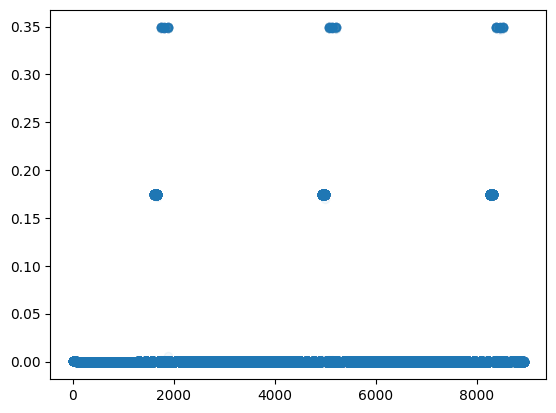

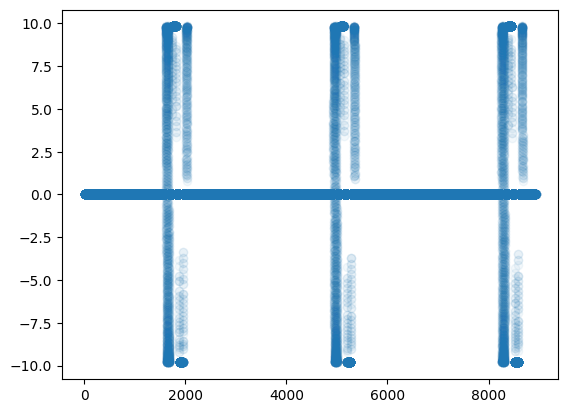

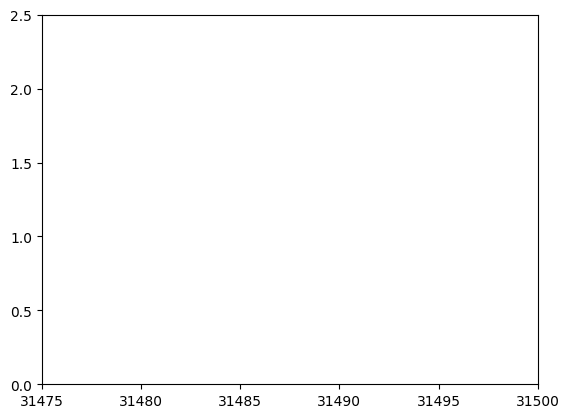

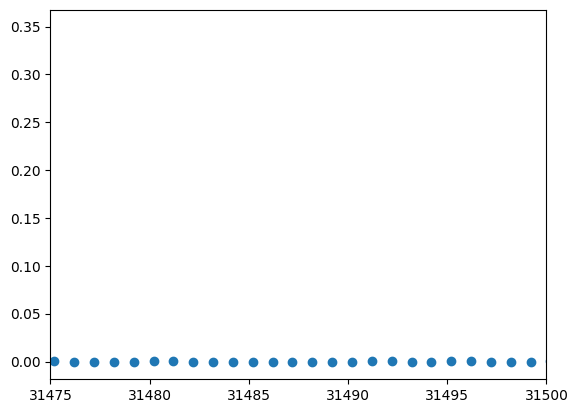

         1         2         3      10     11    12     13
0  0.000010  0.000056  0.000039  22.25  22.25  22.3  22.27
1 -0.000002  0.000054  0.000046  22.25  22.25  22.3  22.27
2 -0.000004  0.000066  0.000038  22.25  22.25  22.3  22.27
3 -0.000002  0.000058  0.000039  22.25  22.25  22.3  22.27
4  0.000007  0.000060  0.000040  22.25  22.25  22.3  22.27
         1         2         3      10     11    12        14        15  \
0  0.000010  0.000056  0.000039  22.25  22.25  22.3  0.000221  0.001250   
1 -0.000002  0.000054  0.000046  22.25  22.25  22.3 -0.000051  0.001209   
2 -0.000004  0.000066  0.000038  22.25  22.25  22.3 -0.000098  0.001461   
3 -0.000002  0.000058  0.000039  22.25  22.25  22.3 -0.000040  0.001291   
4  0.000007  0.000060  0.000040  22.25  22.25  22.3  0.000163  0.001326   

         16        17        18        19        20        21        22  \
0  0.000858  0.004915  0.027803  0.019087  0.109348  0.618622  0.424685   
1  0.001022 -0.001139  0.026908  0.022743 -0.

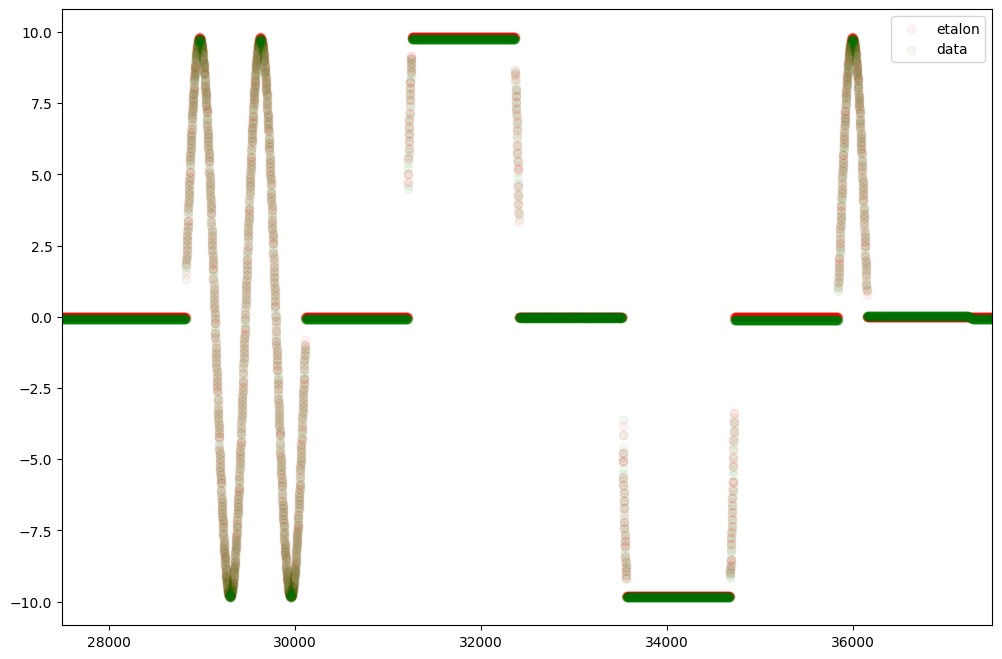

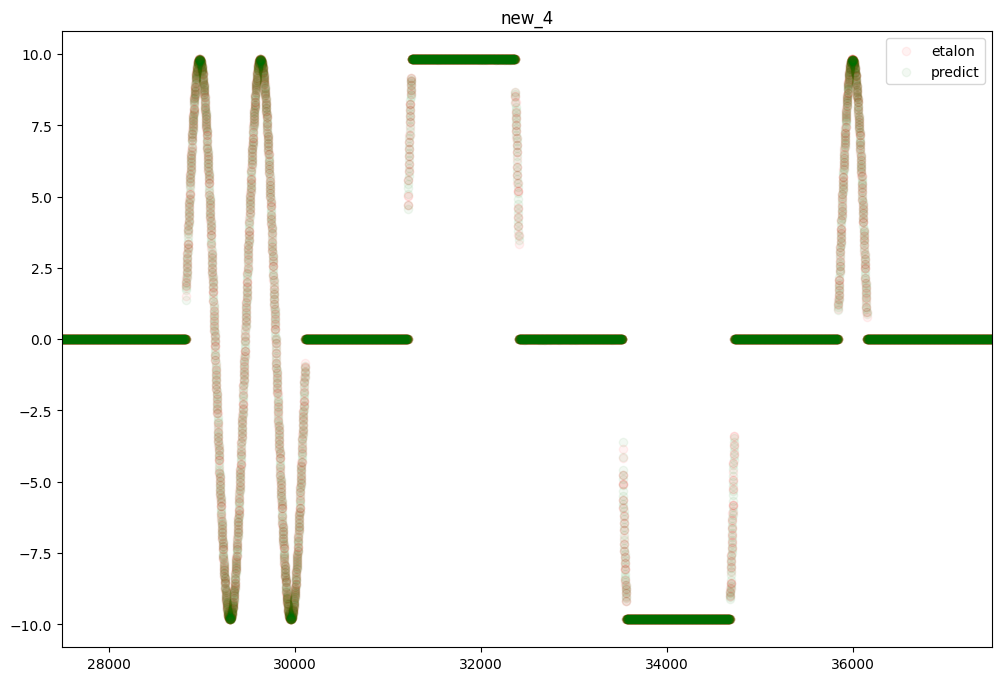

Error for w before: 0.004505701555646887
Error for w after: 0.00011623124144264067


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


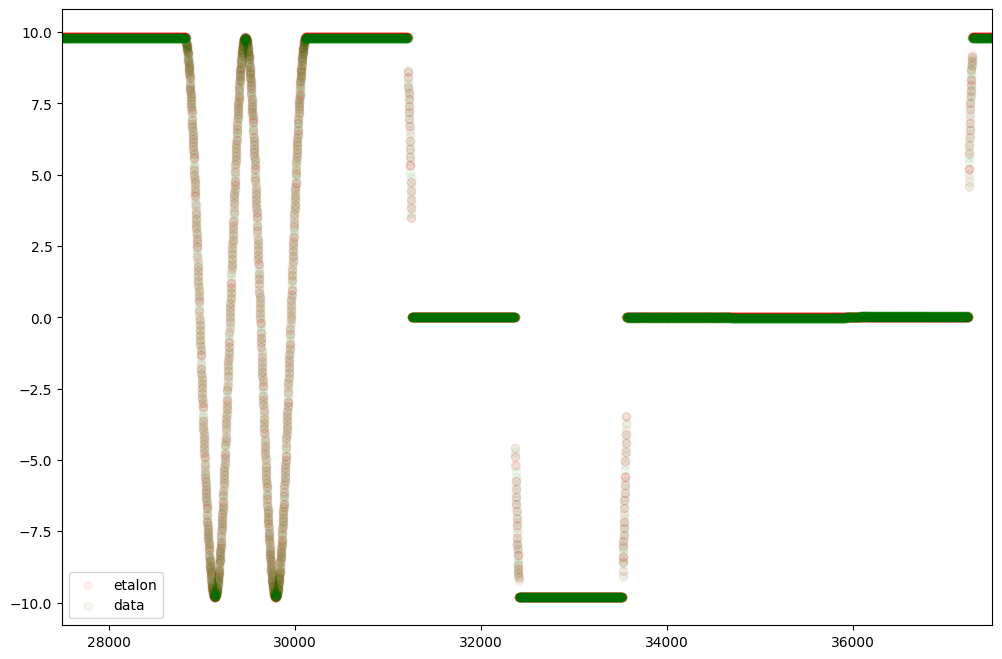

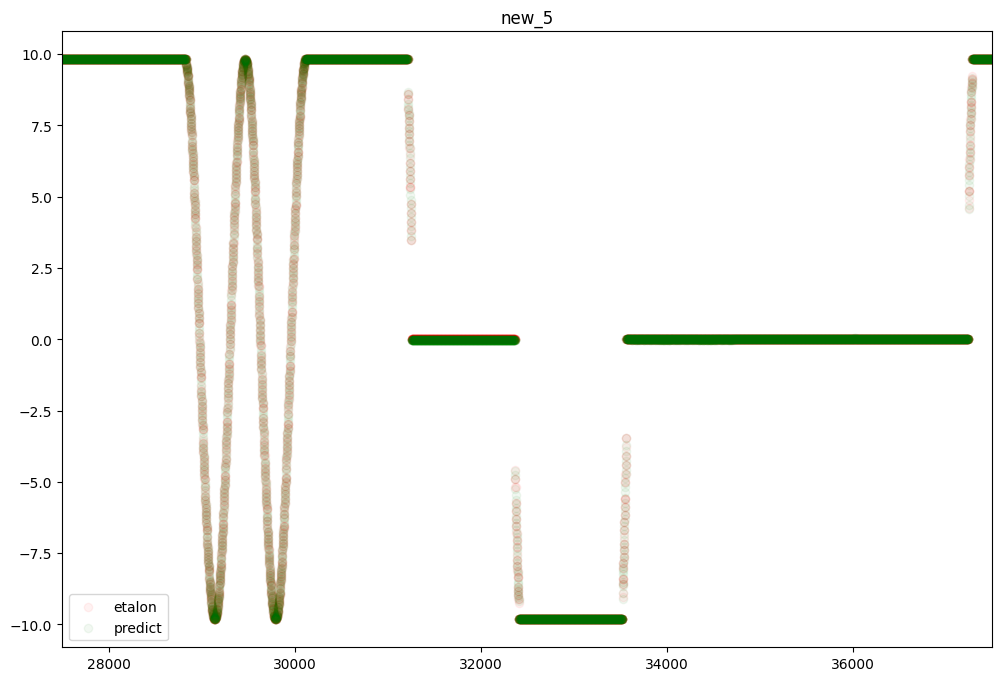

Error for w before: 0.0004577912608346865
Error for w after: 0.00013718225878370864


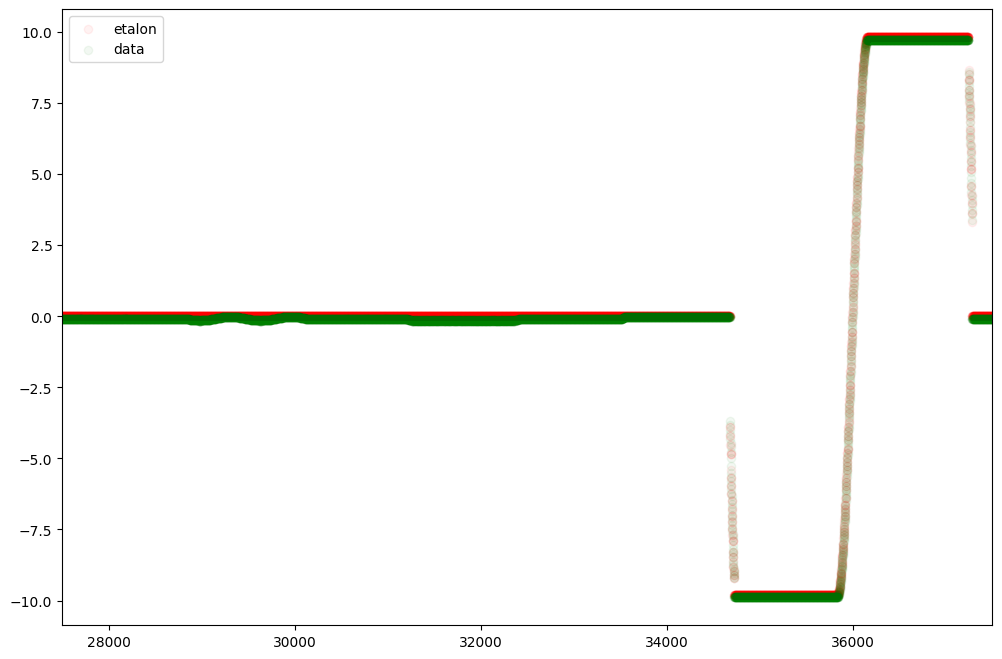

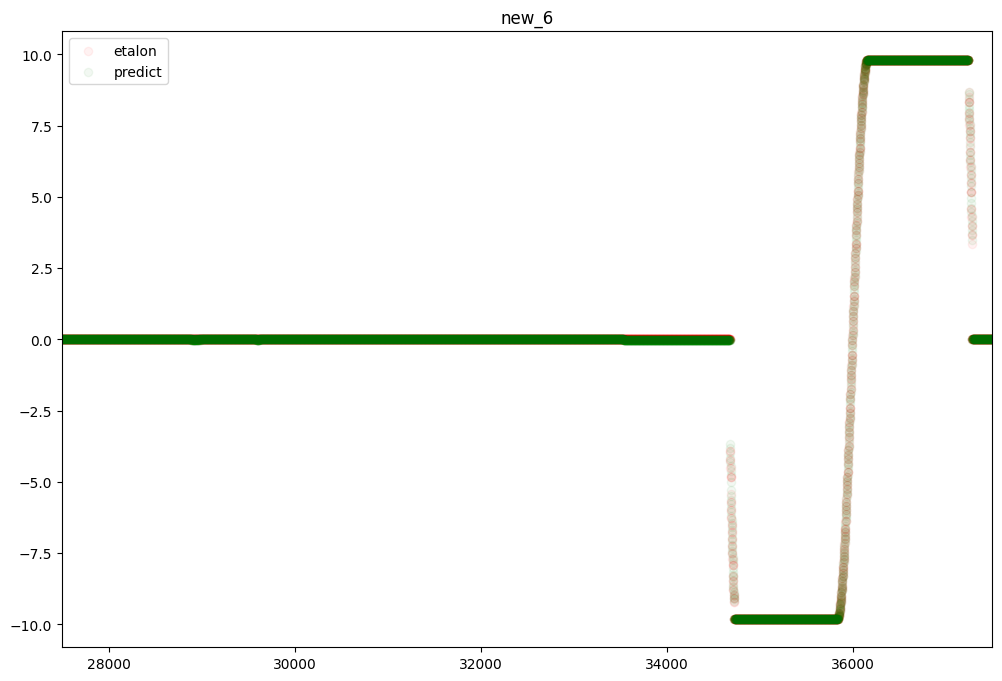

Error for w before: 0.007049012113829307
Error for w after: 9.316973247929045e-05


{'omega_1': [array([-8.22874160e-01, -6.79569711e-02, -2.35489344e-01,  4.11072636e-04,
          7.93717047e-06,  1.26319254e-05,  2.25399258e-01,  8.81057683e-03,
          2.83457472e-02, -9.28207668e-03, -3.71691496e-04, -1.17022541e-03,
          1.27305657e-04,  5.22309266e-06,  1.60984998e-05, -1.84112144e-05,
          2.61213562e-07,  2.87467130e-05]),
  np.float64(-0.0033656651587402235)],
 'omega_2': [array([ 5.86152376e-01,  1.57880577e+00, -1.67430830e+00, -1.48063476e-04,
          2.59222812e-03, -1.70763584e-04, -7.26655118e-02, -7.40177736e-02,
          2.04692173e-01,  2.99129825e-03,  3.15338804e-03, -8.33352961e-03,
         -4.10200776e-05, -4.47518270e-05,  1.13030066e-04, -9.38008270e-05,
          1.28886679e-06, -5.01909593e-04]),
  np.float64(-0.018344046611391236)],
 'omega_3': [array([ 1.09052930e-02,  2.92455178e-01,  1.46693870e+00,  8.37909958e-06,
          1.13030198e-05,  9.94311801e-04, -6.08374091e-04, -3.76261387e-02,
         -5.60771999e-02,  2.8

In [65]:
full_LogicticRegression(file_path_data, file_path_etalon)

In [66]:
def print_coefs(filename, coefs_dict):
  coefs_w1 = coefs_dict['w_1']
  KA10 = coefs_w1[0][0] - 1
  KA11 = coefs_w1[0][7]
  KA12 = coefs_w1[0][10]
  KA13 = coefs_w1[0][13]
  GA120 = coefs_w1[0][1]
  GA121 = coefs_w1[0][8]
  GA122 = coefs_w1[0][11]
  GA123 = coefs_w1[0][14]
  GA130 = coefs_w1[0][2]
  GA131 = coefs_w1[0][9]
  GA132 = coefs_w1[0][12]
  GA133 = coefs_w1[0][15]
  a10 = - coefs_w1[1]
  a11 = -coefs_w1[0][3]
  a12 = - coefs_w1[0][16]
  a13 = -coefs_w1[0][17]
  a1MKD = -coefs_w1[0][6]

  coefs_w2 = coefs_dict['w_2']
  KA20 = coefs_w2[0][1] - 1
  KA21 = coefs_w2[0][8]
  KA22 = coefs_w2[0][11]
  KA23 = coefs_w2[0][12]
  GA220 = coefs_w2[0][0]
  GA221 = coefs_w2[0][7]
  GA222 = coefs_w2[0][10]
  GA223 = coefs_w2[0][13]
  GA230 = coefs_w2[0][2]
  GA231 = coefs_w2[0][9]
  GA232 = coefs_w2[0][12]
  GA233 = coefs_w2[0][15]
  a20 = - coefs_w2[1]
  a21 = -coefs_w2[0][4]
  a22 = - coefs_w2[0][16]
  a23 = -coefs_w2[0][17]
  a2MKD = -coefs_w2[0][6]

  coefs_w3 = coefs_dict['w_3']
  KA30 = coefs_w3[0][2] - 1
  KA31 = coefs_w3[0][9]
  KA32 = coefs_w3[0][12]
  KA33 = coefs_w3[0][15]
  GA320 = coefs_w3[0][0]
  GA321 = coefs_w3[0][7]
  GA322 = coefs_w3[0][10]
  GA323 = coefs_w3[0][13]
  GA330 = coefs_w3[0][1]
  GA331 = coefs_w3[0][8]
  GA332 = coefs_w3[0][11]
  GA333 = coefs_w3[0][14]
  a30 = - coefs_w3[1]
  a31 = -coefs_w3[0][5]
  a32 = - coefs_w3[0][16]
  a33 = -coefs_w3[0][17]
  a3MKD = -coefs_w3[0][6]

  coefs_lg1 = coefs_dict['omega_1']
  k10 = coefs_lg1[0][0] - 1
  k11 = coefs_lg1[0][6]
  k12 = coefs_lg1[0][9]
  k13 = coefs_lg1[0][12]
  G120 = coefs_lg1[0][1]
  G121 = coefs_lg1[0][7]
  G122 = coefs_lg1[0][10]
  G123 = coefs_lg1[0][13]
  G130 = coefs_lg1[0][2]
  G131 = coefs_lg1[0][8]
  G132 = coefs_lg1[0][11]
  G133 = coefs_lg1[0][14]
  alg10 = - coefs_lg1[1]
  alg11 = -coefs_lg1[0][3]
  alg12 = - coefs_lg1[0][15]
  alg13 = -coefs_lg1[0][16]
  a1lgMKD = -coefs_lg1[0][17]

  coefs_lg2 = coefs_dict['omega_2']
  k20 = coefs_lg2[0][1] - 1
  k21 = coefs_lg2[0][7]
  k22 = coefs_lg2[0][10]
  k23 = coefs_lg2[0][13]
  G210 = coefs_lg2[0][0]
  G211 = coefs_lg2[0][6]
  G212 = coefs_lg2[0][9]
  G213 = coefs_lg2[0][12]
  G230 = coefs_lg2[0][2]
  G231 = coefs_lg2[0][8]
  G232 = coefs_lg2[0][11]
  G233 = coefs_lg2[0][14]
  alg20 = - coefs_lg2[1]
  alg21 = -coefs_lg2[0][4]
  alg22 = - coefs_lg2[0][15]
  alg23 = -coefs_lg2[0][16]
  a2lgMKD = -coefs_lg2[0][17]

  coefs_lg3 = coefs_dict['omega_3']
  k30 = coefs_lg3[0][2] - 1
  k31 = coefs_lg3[0][8]
  k32 = coefs_lg3[0][11]
  k33 = coefs_lg3[0][14]
  G310 = coefs_lg3[0][0]
  G311 = coefs_lg3[0][6]
  G312 = coefs_lg3[0][9]
  G313 = coefs_lg3[0][12]
  G320 = coefs_lg3[0][1]
  G321 = coefs_lg3[0][7]
  G322 = coefs_lg3[0][10]
  G323 = coefs_lg3[0][13]
  alg30 = - coefs_lg3[1]
  alg31 = -coefs_lg3[0][5]
  alg32 = - coefs_lg3[0][15]
  alg33 = -coefs_lg3[0][16]
  a3lgMKD = -coefs_lg3[0][17]


  with open(filename, 'w') as f:
    for i in range(27):
      f.write('\n')
    f.write('T0=0.000000000000000E+00;град.С \n')
    f.write('M[00]=1.000000000000000E+00;б/р\n')
    f.write('M[01]=0.000000000000000E+00;б/р\n')
    f.write('M[02]=0.000000000000000E+00;б/р\n')
    f.write('M[10]=0.000000000000000E+00;б/р\n')
    f.write('M[11]=1.000000000000000E+00;б/р\n')
    f.write('M[12]=0.000000000000000E+00;б/р\n')
    f.write('M[20]=0.000000000000000E+00;б/р\n')
    f.write('M[21]=0.000000000000000E+00;б/р\n')
    f.write('M[22]=1.000000000000000E+00;б/р\n')

    f.write('[AC1] \n')
    f.write(f"KA10 = {KA10}\n")
    f.write(f"KA11 = {KA11}\n")
    f.write(f"KA12 = {KA12}\n")
    f.write(f"KA13 = {KA13}\n")
    f.write(f"a10 = {a10}\n")
    f.write(f"a11 = {a11}\n")
    f.write(f"a12 = {a12}\n")
    f.write(f"a13 = {a13}\n")
    f.write(f"a1MKD = {a1MKD}\n")

    f.write(f"GA120 = {GA120}\n")
    f.write(f"GA121 = {GA121}\n")
    f.write(f"GA122 = {GA122}\n")
    f.write(f"GA123 = {GA123}\n")
    f.write(f"GA130 = {GA130}\n")
    f.write(f"GA131 = {GA131}\n")
    f.write(f"GA132 = {GA132}\n")
    f.write(f"GA133 = {GA133}\n")


    f.write('[AC2] \n')
    f.write(f"KA20 = {KA20}\n")
    f.write(f"KA21 = {KA21}\n")
    f.write(f"KA22 = {KA22}\n")
    f.write(f"KA23 = {KA23}\n")
    f.write(f"a20 = {a20}\n")
    f.write(f"a21 = {a21}\n")
    f.write(f"a22 = {a22}\n")
    f.write(f"a23 = {a23}\n")
    f.write(f"a2MKD = {a2MKD}\n")

    f.write(f"GA220 = {GA220}\n")
    f.write(f"GA221 = {GA221}\n")
    f.write(f"GA222 = {GA222}\n")
    f.write(f"GA223 = {GA223}\n")
    f.write(f"GA230 = {GA230}\n")
    f.write(f"GA231 = {GA231}\n")
    f.write(f"GA232 = {GA232}\n")
    f.write(f"GA233 = {GA233}\n")


    f.write('[AC3] \n')
    f.write(f"KA30 = {KA30}\n")
    f.write(f"KA31 = {KA31}\n")
    f.write(f"KA32 = {KA32}\n")
    f.write(f"KA33 = {KA33}\n")
    f.write(f"a30 = {a30}\n")
    f.write(f"a31 = {a31}\n")
    f.write(f"a32 = {a32}\n")
    f.write(f"a33 = {a33}\n")
    f.write(f"a3MKD = {a3MKD}\n")

    f.write(f"GA320 = {GA320}\n")
    f.write(f"GA321 = {GA321}\n")
    f.write(f"GA322 = {GA322}\n")
    f.write(f"GA323 = {GA323}\n")
    f.write(f"GA330 = {GA330}\n")
    f.write(f"GA331 = {GA331}\n")
    f.write(f"GA332 = {GA332}\n")
    f.write(f"GA333 = {GA333}\n")

    #Тут нужны гироскопы
    f.write('[LG1]')

    f.write(f'dK[0]={k10};\n')
    f.write(f'dK[1]={k11};\n')
    f.write(f'dK[2]={k12};\n')
    f.write(f'dK[3]={k13};\n')

    f.write(f'dw[0]={alg10};\n')
    f.write(f'dw[1]={alg11};\n')
    f.write(f'dw[2]={alg12};\n')
    f.write(f'dw[3]={alg13};\n')

    f.write(f'mA={a1lgMKD};\n')
    f.write(f'mmA=0;\n')

    f.write(f'G[10]={G120};\n')
    f.write(f'G[11]={G121};\n')
    f.write(f'G[12]={G122};\n')
    f.write(f'G[13]={G123};\n')
    f.write(f'G[20]={G130};\n')
    f.write(f'G[21]={G131};\n')
    f.write(f'G[22]={G132};\n')
    f.write(f'G[23]={G133};\n')

    f.write('[LG2]')

    f.write(f'dK[0]={k20};\n')
    f.write(f'dK[1]={k21};\n')
    f.write(f'dK[2]={k22};\n')
    f.write(f'dK[3]={k23};\n')

    f.write(f'dw[0]={alg20};\n')
    f.write(f'dw[1]={alg21};\n')
    f.write(f'dw[2]={alg22};\n')
    f.write(f'dw[3]={alg23};\n')

    f.write(f'mA={a2lgMKD};\n')
    f.write(f'mmA=0;\n')

    f.write(f'G[10]={G210};\n')
    f.write(f'G[11]={G211};\n')
    f.write(f'G[12]={G212};\n')
    f.write(f'G[13]={G213};\n')
    f.write(f'G[20]={G230};\n')
    f.write(f'G[21]={G231};\n')
    f.write(f'G[22]={G232};\n')
    f.write(f'G[23]={G233};\n')


    f.write('[LG3]')

    f.write(f'dK[0]={k30};\n')
    f.write(f'dK[1]={k31};\n')
    f.write(f'dK[2]={k32};\n')
    f.write(f'dK[3]={k33};\n')

    f.write(f'dw[0]={alg30};\n')
    f.write(f'dw[1]={alg31};\n')
    f.write(f'dw[2]={alg32};\n')
    f.write(f'dw[3]={alg33};\n')

    f.write(f'mA={a3lgMKD};\n')
    f.write(f'mmA=0;\n')

    f.write(f'G[10]={G310};\n')
    f.write(f'G[11]={G311};\n')
    f.write(f'G[12]={G312};\n')
    f.write(f'G[13]={G313};\n')
    f.write(f'G[20]={G320};\n')
    f.write(f'G[21]={G321};\n')
    f.write(f'G[22]={G322};\n')
    f.write(f'G[23]={G323};\n')

[ 25358  25359  25360 ... 154737 154738 154740]


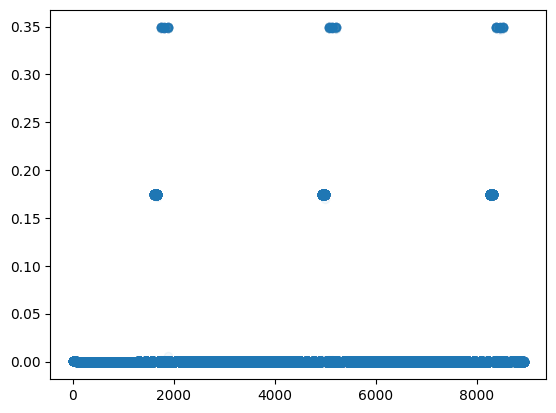

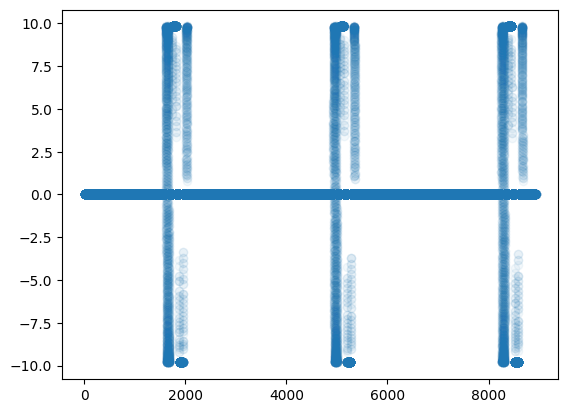

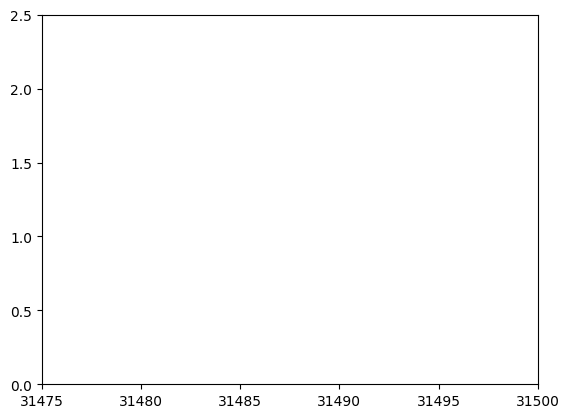

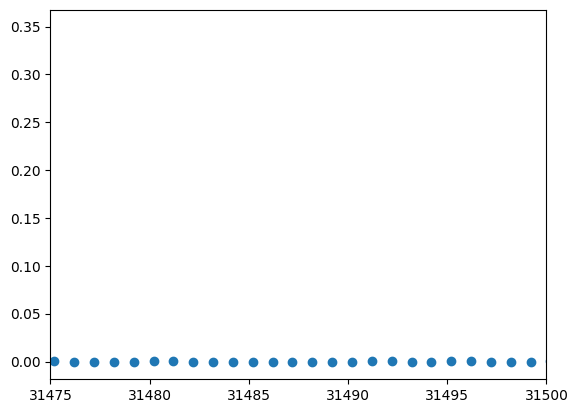

         1         2         3      10     11    12     13
0  0.000010  0.000056  0.000039  22.25  22.25  22.3  22.27
1 -0.000002  0.000054  0.000046  22.25  22.25  22.3  22.27
2 -0.000004  0.000066  0.000038  22.25  22.25  22.3  22.27
3 -0.000002  0.000058  0.000039  22.25  22.25  22.3  22.27
4  0.000007  0.000060  0.000040  22.25  22.25  22.3  22.27
         1         2         3      10     11    12        14        15  \
0  0.000010  0.000056  0.000039  22.25  22.25  22.3  0.000221  0.001250   
1 -0.000002  0.000054  0.000046  22.25  22.25  22.3 -0.000051  0.001209   
2 -0.000004  0.000066  0.000038  22.25  22.25  22.3 -0.000098  0.001461   
3 -0.000002  0.000058  0.000039  22.25  22.25  22.3 -0.000040  0.001291   
4  0.000007  0.000060  0.000040  22.25  22.25  22.3  0.000163  0.001326   

         16        17        18        19        20        21        22  \
0  0.000858  0.004915  0.027803  0.019087  0.109348  0.618622  0.424685   
1  0.001022 -0.001139  0.026908  0.022743 -0.

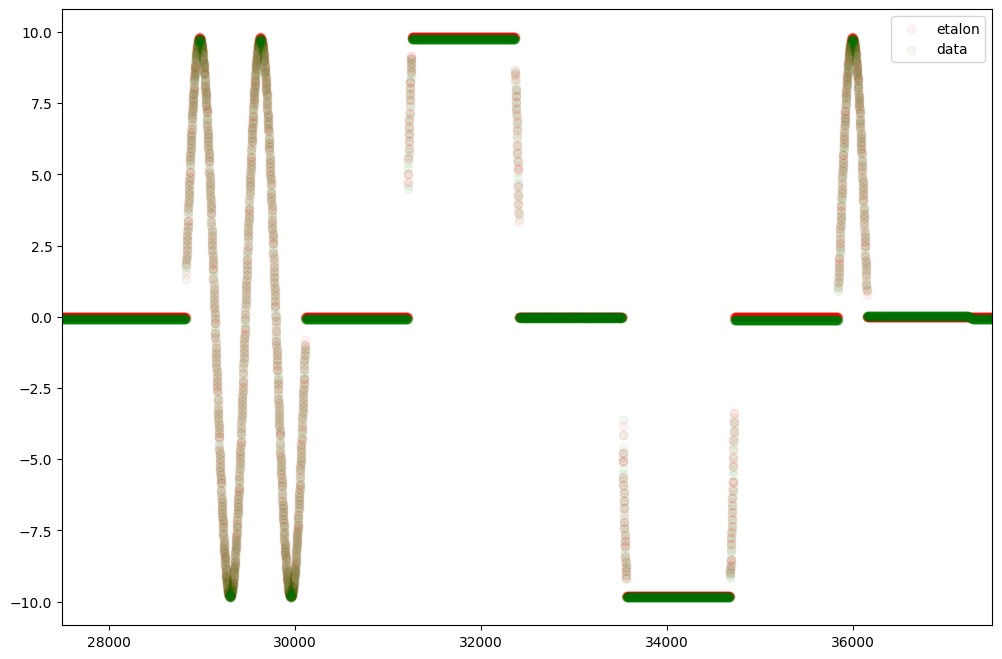

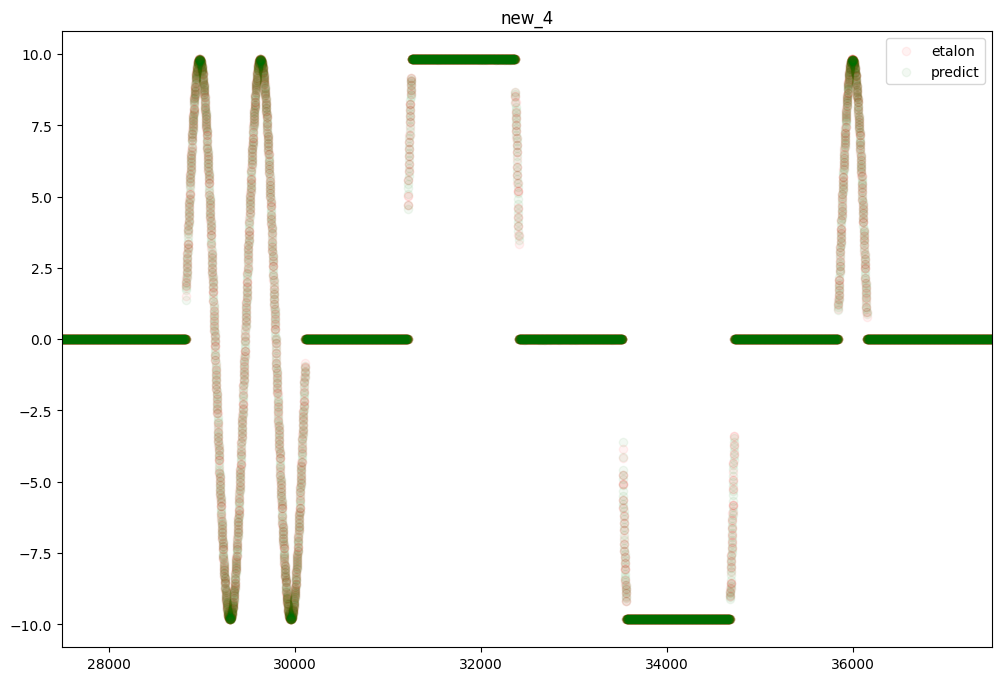

Error for w before: 0.004505701555646887
Error for w after: 0.00011623124144264067


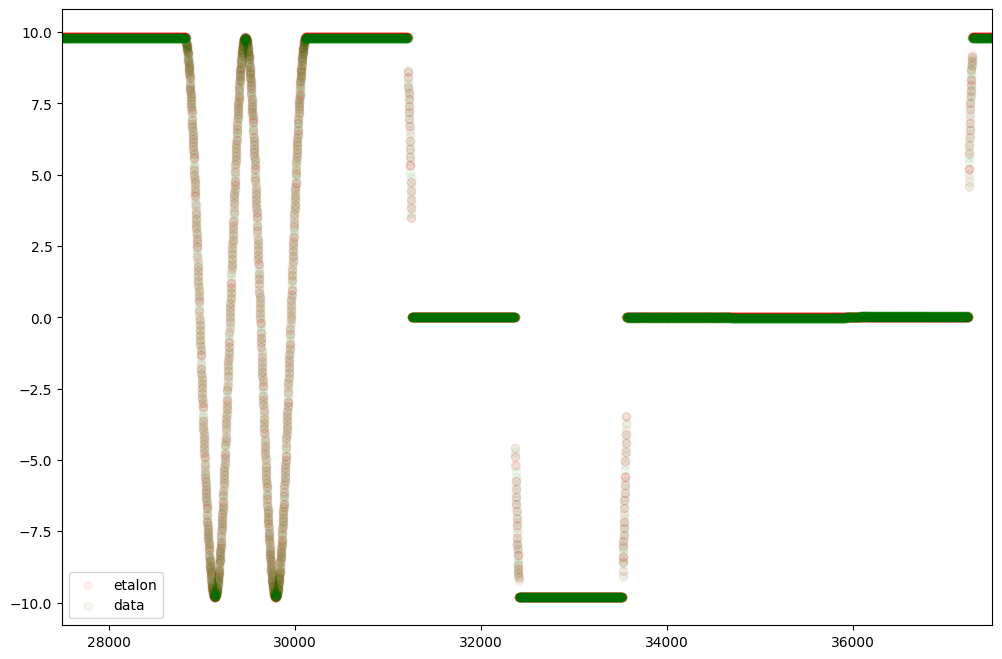

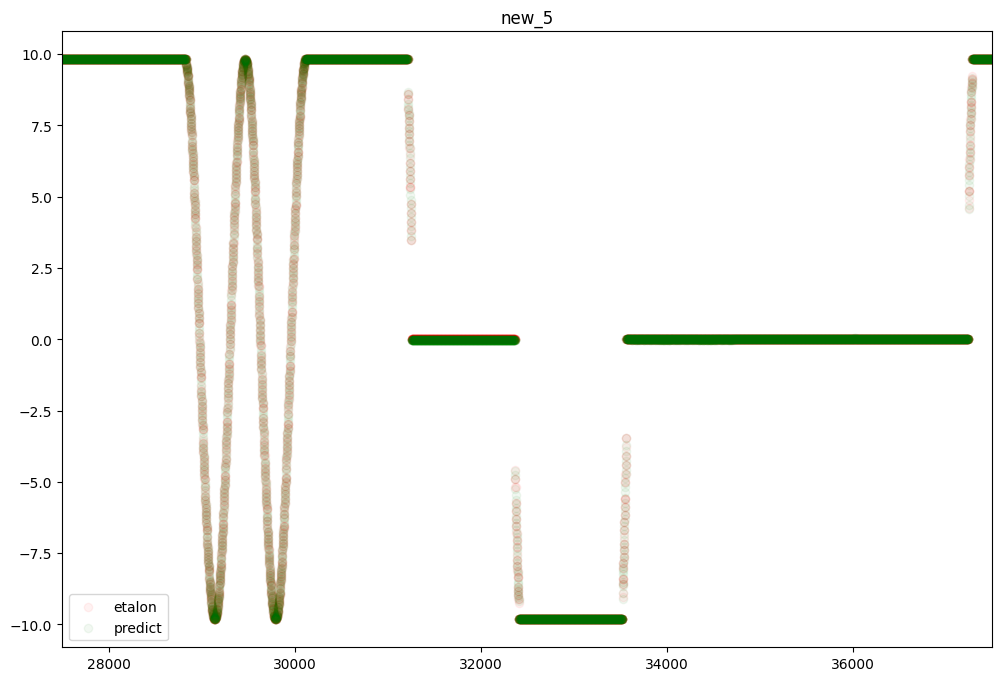

Error for w before: 0.0004577912608346865
Error for w after: 0.00013718225878370864


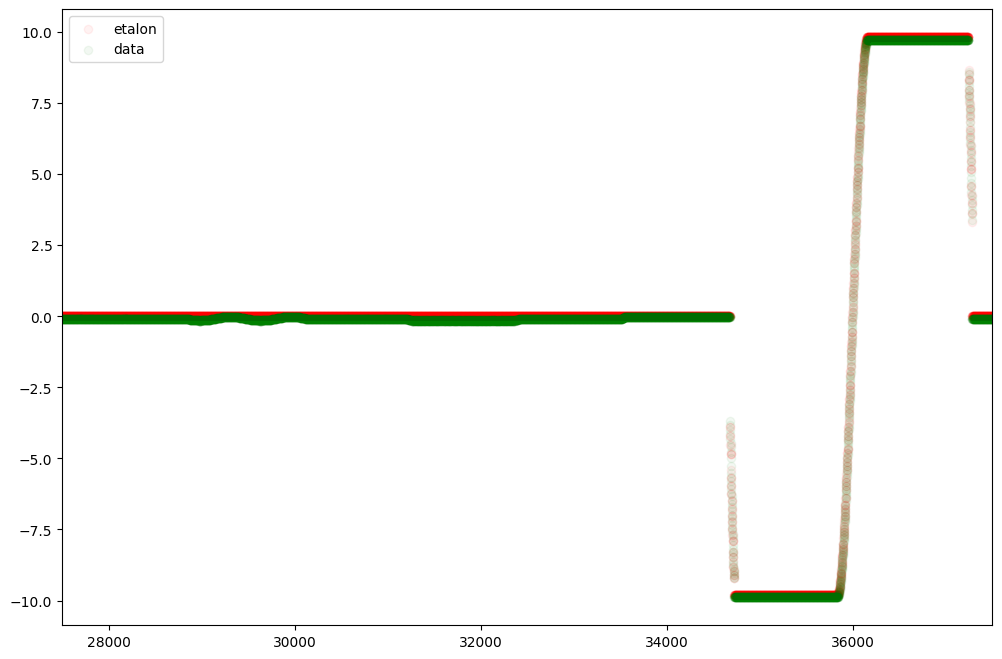

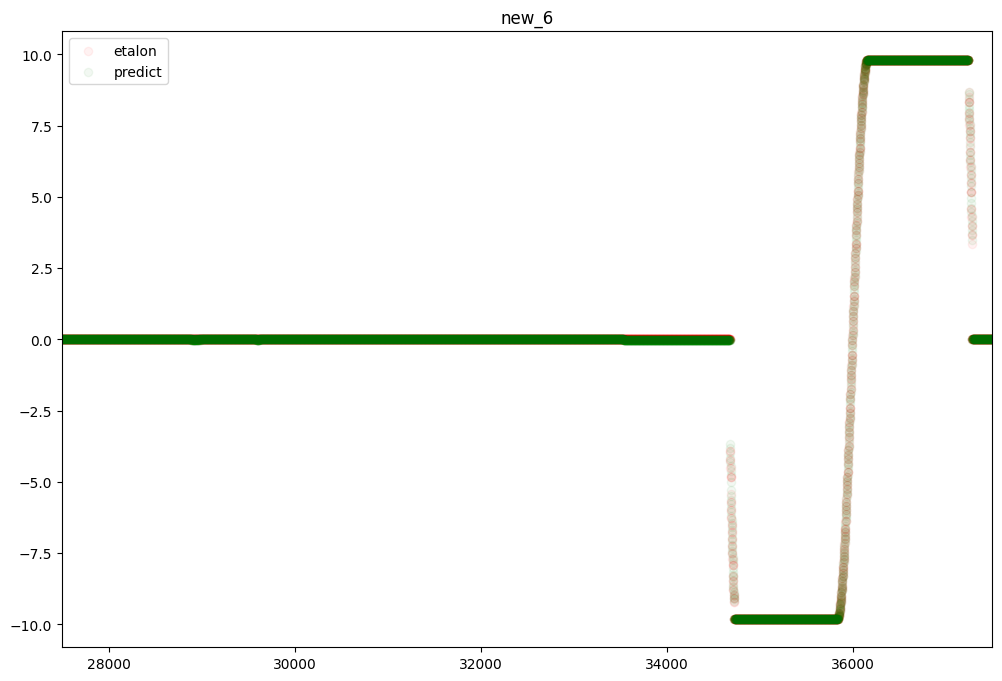

Error for w before: 0.007049012113829307
Error for w after: 9.316973247929045e-05


In [67]:
print_coefs('coefs', full_LogicticRegression(file_path_data, file_path_etalon))